# Show and Tell model training - attention based
### Based on link: https://www.tensorflow.org/tutorials/text/image_captioning

### The model architecture is similar to Show, Attend and Tell: Neural Image Caption Generation with Visual Attention.
#### Arch paper: https://arxiv.org/abs/1502.03044

# Training model on images of Coco_Train2017 dataset by splitting into Train and Test parts.

## First phase of training already done and pickled various files to resume training with the data being split in a deterministic manner.

### The encoder is pre-trained Google Inception-v3 trained on Imagenet.
### All the 118k images run through encoder already and the data is saved as .npy files. Uploaded as kaggle dataset:
### https://www.kaggle.com/pandasudipt/rohits-encodings   = 57 gb file

## AVAILABLE data :
### Coco_Train2017     = has 118287 images
### Coco_Val2017       = has 5000   images
### Combined total     = 123287     images

## USED data :
## Only 100k images of the Coco_Train2017 dataset.
### In each run, split with 95:05 = Train:Test ratio
### Kept aside 5k images for bleu scoring after model is trained

### Note: 1) Each image will have multiple captions (up to 5 as some may be discarded)
###       2) Not using the Coco_Test2017 dataset at all as it has no annotations json file which has the captions.

In [ ]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning

#import collections
#import random
#import re
#from glob import glob
#from PIL import Image

In [1]:
import os
import sys
import json
import time
import datetime
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
import matplotlib.pyplot as plt
import re
import pickle
from glob import glob
import collections
import random
import PIL
#import itertools
#import PIL.Image

## to be able to download files from output directory of kaggle
from IPython.display import FileLink

## for emailing
import smtplib
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.header import Header

#from zipfile import ZipFile 

In [101]:
DUMMY_RUN_FLAG = False
DUMMY_RUN_FLAG

False

In [3]:
os.getcwd()

'/kaggle/working'

In [ ]:
#from google.colab import drive
#drive.flush_and_unmount()
#drive.mount('/content/gdrive')

In [4]:
!ls '../'

input  lib  working


In [5]:
!ls '../input/'

coco-2017-dataset  rohits-encodings  thesis-imgcapattention-weights-in-run3


In [6]:
!ls '../input/coco-2017-dataset/coco2017/'

annotations  test2017  train2017  val2017


In [7]:
!ls '../input/coco-2017-dataset/coco2017/annotations/'

captions_train2017.json   instances_val2017.json
captions_val2017.json	  person_keypoints_train2017.json
instances_train2017.json  person_keypoints_val2017.json


In [8]:
!ls '../input/coco-2017-dataset/coco2017/train2017/' | wc -l

118287


In [9]:
!ls '../input/rohits-encodings/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_saved_encodings_TRAIN_118k/' | wc -l

118287


In [10]:
!ls '../input/thesis-imgcapattention-weights-in-run3/'

ATTEND_Decoder_wts_ep_8.h5


In [11]:
!ls '../working/'

__notebook_source__.ipynb


In [12]:
!mkdir '../working/weights_out/'
!mkdir '../working/chkpt_out/'
!mkdir '../working/saved_model/'

In [13]:
!ls '../working/'

__notebook_source__.ipynb  chkpt_out  saved_model  weights_out


In [14]:
!ls '../working/weights_out/'

In [15]:
!ls '/kaggle/working/weights_out/'

In [16]:
!ls '../working/chkpt_out/'

In [17]:
!ls '../working/saved_model/'

In [ ]:
#!rm -r '../working/weights_out/'

In [ ]:
#!rm -r '../working/chkpt_out/'

In [ ]:
#!rm -r '../working/saved_model/'

In [18]:
## Kaggle versions

## Weights from training till now
OPDIR = r'../working/'

## New weights to save here
OPDIR_WEIGHTS = r'../working/weights_out/'

## Training checkpoint directory
CHKPT_DIR_OUT = r'../working/chkpt_out/'

## Saved model directory
#SAVED_MODEL_DIR_OUT = r'../working/saved_model/'

## Images locations
IPDIR_IMGS_COCO_TRAIN = r'../input/coco-2017-dataset/coco2017/train2017/'

## Attention model encodings saved as .npy files here for all the 118k train images
IPDIR_SAVED_ENCODINGS =  r'../input/rohits-encodings/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_saved_encodings_TRAIN_118k/'

## Annotations location
IPDIR_ANNO = r'../input/coco-2017-dataset/coco2017/annotations/'

## Weights from previous stage of training
IPDIR_WEIGHTS_IN = r'../input/thesis-imgcapattention-weights-in-run3/'

In [19]:
## VERIFY IT IS TRUE
os.path.exists(OPDIR_WEIGHTS), os.path.exists(CHKPT_DIR_OUT), os.path.exists(IPDIR_SAVED_ENCODINGS), os.path.exists(IPDIR_WEIGHTS_IN)#, os.path.exists(SAVED_MODEL_DIR_OUT), 

(True, True, True, True)

# Prepare the data

In [102]:
PATH = os.path.abspath(IPDIR_IMGS_COCO_TRAIN) + r'/'
PATH

'/kaggle/input/coco-2017-dataset/coco2017/train2017/'

In [103]:
!ls '/kaggle/input/coco-2017-dataset/coco2017/train2017/' | wc -l

118287


In [104]:
os.path.exists(PATH + '000000044704.jpg')

True

In [105]:
IPDIR_ANNO

'../input/coco-2017-dataset/coco2017/annotations/'

In [106]:
with open(IPDIR_ANNO+'captions_train2017.json', 'r') as f:
    annotations = json.load(f)

## set MAX_IMAGES_FOR_TRAINING

In [107]:
if DUMMY_RUN_FLAG == True:
    MAX_IMAGES_FOR_TRAINING = 5
else:
    MAX_IMAGES_FOR_TRAINING = 100000
MAX_IMAGES_FOR_TRAINING

100000

In [108]:
print(f"Start time = {datetime.datetime.now().strftime('%H:%M:%S')}")

## Group all captions together having the same image ID.
##    Add the start and end sequence tokens at each end of existing captions


image_path_to_caption = collections.defaultdict(list)
for value in annotations['annotations']:
    caption = f"<start> {value['caption']} <end>"
    image_path = PATH + '%012d.jpg' % (value['image_id'])
    image_path_to_caption[image_path].append(caption)

print(f"End time = {datetime.datetime.now().strftime('%H:%M:%S')}")

Start time = 15:15:32
End time = 15:15:33


In [109]:
len(image_path_to_caption)

118287

In [110]:
list(image_path_to_caption.keys())[:2]

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000203564.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000322141.jpg']

In [111]:
list(image_path_to_caption.items())[:2]

[('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000203564.jpg',
  ['<start> A bicycle replica with a clock as the front wheel. <end>',
   '<start> The bike has a clock as a tire. <end>',
   '<start> A black metal bicycle with a clock inside the front wheel. <end>',
   '<start> A bicycle figurine in which the front wheel is replaced with a clock\n <end>',
   '<start> A clock with the appearance of the wheel of a bicycle  <end>']),
 ('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000322141.jpg',
  ['<start> A room with blue walls and a white sink and door. <end>',
   '<start> Blue and white color scheme in a small bathroom. <end>',
   '<start> This is a blue and white bathroom with a wall sink and a lifesaver on the wall. <end>',
   '<start> A blue boat themed bathroom with a life preserver on the wall <end>',
   '<start> A bathroom with walls that are painted baby blue. <end>'])]

In [112]:
print(f"len should be = 118287\nActual value = {len(list(image_path_to_caption.keys()))}")

len should be = 118287
Actual value = 118287


## Keep only 100k images
## Set aside 5k from this as the images to do Bleu score evaluation

In [113]:
image_paths = list(image_path_to_caption.keys())[:MAX_IMAGES_FOR_TRAINING]
print(f"Count of images used for training = {len(image_paths)}")

Count of images used for training = 100000


In [32]:
#images_5k_for_bleu_scoring = [os.path.basename(v) for v in list(image_path_to_caption.keys())[MAX_IMAGES_FOR_TRAINING : MAX_IMAGES_FOR_TRAINING+5000]]
#print(f"Count of images set aside for bleu scoring after model training = {len(images_5k_for_bleu_scoring)}")
#print(f"Few entries =\n{images_5k_for_bleu_scoring[:3]}")

### Done this already and pickled the 5k images

In [114]:
## pickle the 5000 image filenames

# variable = images_5k_for_bleu_scoring
#with open(OPDIR+'ATTEND_images_5k_for_bleu_scoring.pkl', 'wb') as handle:
#  pickle.dump(images_5k_for_bleu_scoring, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [115]:
print(f"Expected length = {MAX_IMAGES_FOR_TRAINING}\n\nlength = {len(image_paths)}")

Expected length = 100000

length = 100000


In [116]:
random.shuffle(image_paths)
train_image_paths = image_paths

In [117]:
## keeping all the images, not reducing to 30k as the tutorial did
print(f"length should be = {MAX_IMAGES_FOR_TRAINING}\n\nactual value = {len(train_image_paths)}")

length should be = 100000

actual value = 100000


In [118]:
## for all images in the subset folder
train_captions = []
img_name_vector = []
for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

In [119]:
train_image_paths[:2]

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000031813.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000418175.jpg']

In [120]:
train_captions[:2]

['<start> A surfer riding his bike to the beach. <end>',
 '<start> a surfer rides his bike down the street <end>']

In [121]:
img_name_vector[:2]

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000031813.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000031813.jpg']

In [122]:
len(img_name_vector)

500281

<start> A surfer riding his bike to the beach. <end>


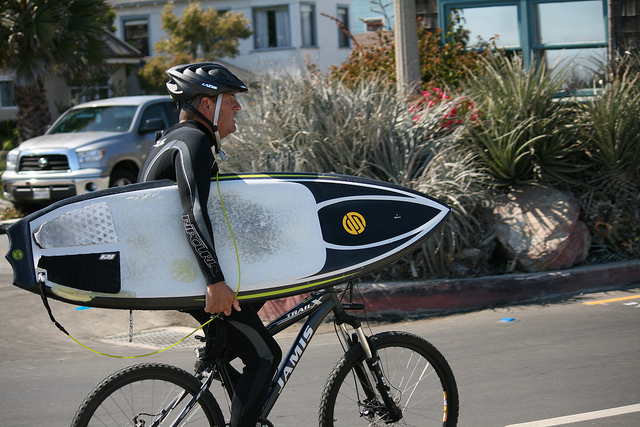

In [123]:
print(train_captions[0])
PIL.Image.open(img_name_vector[0])

# Preprocess and tokenize the captions

### First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
### Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
### You then create word-to-index and index-to-word mappings.
### Finally, you pad all sequences to be the same length as the longest one.

In [124]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [125]:
train_captions[:2]

['<start> A surfer riding his bike to the beach. <end>',
 '<start> a surfer rides his bike down the street <end>']

In [126]:
len(train_captions)

500281

In [127]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [128]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [129]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [130]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [131]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
print(f"max_length = {max_length}")

max_length = 52


In [132]:
## Setting max_length to 52 as that was the length in the full 118k data
max_length = 52
max_length

52

In [133]:
OPDIR

'../working/'

In [ ]:
## ONE-TIME-ONLY

## pickle the tokenizer for use during inference stage later on

# variable tokenizer
#with open(OPDIR + 'tokenizer_from_training_100k.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
#print(f"Pickled tokenizer")

## Split the data into training and testing

### used split ratio of 95:5
### For total whatever count of images in this subset
#### Total         data points = len(img_name_vector)
#### Train         data points = train % ratio
#### Test          data points = test  % ratio

In [134]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 95-05 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
slice_index = int(len(img_keys)*0.95)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [135]:
len(img_name_vector), len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(500281, 475266, 475266, 25015, 25015)

In [136]:
len(img_to_cap_vector)

100000

In [137]:
img_name_train[:2]

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000409856.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000409856.jpg']

In [138]:
cap_train[:2]

[array([  3,   2,  33, 259,  26,  33, 174,  21,  13,  16, 258,   4,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       dtype=int32),
 array([  3,   2,  33,   8,   7, 585,  11, 417, 729,   7, 263,   4,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       dtype=int32)]

# Create a tf.data dataset for training

### Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [139]:
len(img_name_train)

475266

In [140]:
img_name_train[:3]

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000409856.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000409856.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000409856.jpg']

In [141]:
type(img_name_train)

list

In [142]:
IPDIR_SAVED_ENCODINGS

'../input/rohits-encodings/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_saved_encodings_TRAIN_118k/'

In [143]:
## current img_name_train points to the actual .jpg file location.
## Original code expects the .npy file of the saved encoding to also be here - but this is not so in my use case
## so create new list with entries pointing to the encodings location
img_name_train_correct_enc_locs = [IPDIR_SAVED_ENCODINGS + os.path.basename(val) for val in img_name_train]

len(img_name_train_correct_enc_locs)

475266

In [144]:
img_name_train_correct_enc_locs[:3]

['../input/rohits-encodings/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_saved_encodings_TRAIN_118k/000000409856.jpg',
 '../input/rohits-encodings/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_saved_encodings_TRAIN_118k/000000409856.jpg',
 '../input/rohits-encodings/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_saved_encodings_TRAIN_118k/000000409856.jpg']

## CORRECT BATCH_SIZE ?????

In [145]:
# Feel free to change these parameters according to your system's configuration

if DUMMY_RUN_FLAG == True:
    BATCH_SIZE = 1
else:
    BATCH_SIZE = 128
print(f"BATCH_SIZE used = {BATCH_SIZE}")
BUFFER_SIZE = 250
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

BATCH_SIZE used = 128


In [146]:
num_steps

3713

In [147]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [148]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train_correct_enc_locs, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Model
### Fun fact: the decoder below is identical to the one in the example for Neural Machine Translation with Attention (https://www.tensorflow.org/tutorials/sequences/nmt_with_attention).

### The model architecture is inspired by the Show, Attend and Tell paper (https://arxiv.org/pdf/1502.03044.pdf).

### In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
### You squash that to a shape of (64, 2048).
### This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
### The RNN (here GRU) attends over the image to predict the next word.

In [67]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [68]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [69]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [70]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [71]:
type(encoder)

__main__.CNN_Encoder

In [72]:
type(decoder)

__main__.RNN_Decoder

In [73]:
optimizer = tf.keras.optimizers.Adam()

In [74]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [75]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

# Clean after dummy run to prepare for ACTUAL TRAIN

## But can actually run always, if its empty, no effect

#### Clean checkpoint directory
#### Clean weights out directory

In [149]:
CHKPT_DIR_OUT

'../working/chkpt_out/'

In [150]:
os.listdir(CHKPT_DIR_OUT)

['ckpt-1.data-00000-of-00001', 'ckpt-1.index', 'checkpoint']

In [151]:
OPDIR_WEIGHTS

'../working/weights_out/'

In [152]:
os.listdir(OPDIR_WEIGHTS)

['ATTEND_Decoder_wts_ep_9.h5']

In [153]:
DUMMY_RUN_FLAG

False

In [154]:
## always run
for f in os.listdir(CHKPT_DIR_OUT):
    os.remove(CHKPT_DIR_OUT + f)
print(f"Removed all dummy run checkpoint files")

for f in os.listdir(OPDIR_WEIGHTS):
    os.remove(OPDIR_WEIGHTS + f)
print(f"Removed all dummy run weight files")

Removed all dummy run checkpoint files
Removed all dummy run weight files


In [155]:
## make sure EMPTY
os.listdir(CHKPT_DIR_OUT)

[]

In [156]:
## make sure EMPTY
os.listdir(OPDIR_WEIGHTS)

[]

# Reload weights from previous run to continue training

## ONLY if DUMMY_RUN_FLAG is False

In [157]:
IPDIR_WEIGHTS_IN

'../input/thesis-imgcapattention-weights-in-run3/'

In [158]:
os.listdir(IPDIR_WEIGHTS_IN)

['ATTEND_Decoder_wts_ep_8.h5']

In [159]:
prev_wts_file = r'ATTEND_Decoder_wts_ep_8.h5'
prev_wts_file

'ATTEND_Decoder_wts_ep_8.h5'

In [160]:
if DUMMY_RUN_FLAG == False:
    WEIGHTS_FILE_RELOAD = IPDIR_WEIGHTS_IN + prev_wts_file
    print(f"VERIFY: Going to reload this file: {WEIGHTS_FILE_RELOAD}")
    print(f"VERIFY it is TRUE: {os.path.exists(WEIGHTS_FILE_RELOAD)}")
    
    decoder.load_weights(WEIGHTS_FILE_RELOAD)
    print(f"Success reloading weights")
else:
    print(f"NO RELOADING OF WEIGHTS DONE")

VERIFY: Going to reload this file: ../input/thesis-imgcapattention-weights-in-run3/ATTEND_Decoder_wts_ep_8.h5
VERIFY it is TRUE: True
Success reloading weights


# Checkpoint - ALWAYS run for DUMMY and ACTUAL TRAINING

In [161]:
CHKPT_DIR_OUT

'../working/chkpt_out/'

In [162]:
checkpoint_path = CHKPT_DIR_OUT
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

## CORRECT start_epoch ????????

In [163]:
start_epoch = 9
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

# Training

### You extract the features stored in the respective .npy files and then pass those features through the encoder.
### The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
### The decoder returns the predictions and the decoder hidden state.
### The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
### Use teacher forcing to decide the next input to the decoder.
### Teacher forcing is the technique where the target word is passed as the next input to the decoder.
### The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [164]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [92]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    
    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
    
    total_loss = (loss / int(target.shape[1]))
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss, total_loss

In [165]:
OPDIR_WEIGHTS

'../working/weights_out/'

In [166]:
os.listdir(OPDIR_WEIGHTS)

[]

In [167]:
def send_email_NO_zip_GMAIL(_inFile, _epoch):
    sender = 'xxx' # your email address
    receivers = ['xxx','xxx']
    mail_host = 'smtp.gmail.com' # check your email provider's doc

    # email and passwd
    mail_user = 'xxx' # your email address
    mail_pass = 'xxx' # password

    # email
    message = MIMEMultipart()
    message['To'] =  Header('self', 'utf-8') # receive's name, optional
    message['Subject'] = Header(f'Weights file - ep_{_epoch}', 'utf-8') # email subject
    message.attach(MIMEText('New weights file as h5 format', 'plain', 'utf-8')) # email body

    # attachment
    att1 = MIMEApplication(open(_inFile, 'rb').read())
    att1.add_header('Content-Disposition', 'attachment', filename=os.path.basename(_inFile))
    # att1['Content-Type'] = 'application/octet-stream'
    # att1["Content-Disposition"] = 'attachment; filename="simnet.pt"'
    message.attach(att1)

    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.ehlo()
        server.starttls()
        server.ehlo()
        server.login(mail_user, mail_pass)
        server.sendmail(sender, receivers, message.as_string())
        server.quit()
        print(f'\nEMAIL SUCCESS - for epoch {_epoch}\n')
    except smtplib.SMTPException as e_SMPTException:
        print(f'\nEMAIL FAILED - SMTPException - for epoch {_epoch}\n{e_SMPTException}\n')
    except Exception as e_unknown:
        print(f'\nEMAIL FAILED - Unknown - for epoch {_epoch}\n{e_unknown}\n')

In [1]:
#def send_email_NO_zip_YAHOO(_inFile, _epoch):
    sender = 'xxx' # your email address
    receivers = ['xxx','xxx']
    mail_host = 'smtp.gmail.com' # check your email provider's doc

    # email and passwd
    mail_user = 'xxx' # your email address
    mail_pass = 'xxx' # password

    # email
    message = MIMEMultipart()
    message['To'] =  Header('self', 'utf-8') # receive's name, optional
    message['Subject'] = Header(f'Weights file - ep_{_epoch}', 'utf-8') # email subject
    message.attach(MIMEText('New weights file as h5 format', 'plain', 'utf-8')) # email body

    # attachment
    att1 = MIMEApplication(open(_inFile, 'rb').read())
    att1.add_header('Content-Disposition', 'attachment', filename=os.path.basename(_inFile))
    # att1['Content-Type'] = 'application/octet-stream'
    # att1["Content-Disposition"] = 'attachment; filename="simnet.pt"'
    message.attach(att1)

    try:
        server = smtplib.SMTP('smtp.mail.yahoo.com', 587)
        server.ehlo()
        server.starttls()
        server.ehlo()
        server.login(mail_user, mail_pass)
        server.sendmail(sender, receivers, message.as_string())
        server.quit()
        print(f'\nEMAIL SUCCESS - for epoch {_epoch}\n')
    except smtplib.SMTPException as e_SMPTException:
        print(f'\nEMAIL FAILED - SMTPException - for epoch {_epoch}\n{e_SMPTException}\n')
    except Exception as e_unknown:
        print(f'\nEMAIL FAILED - Unknown - for epoch {_epoch}\n{e_unknown}\n')

# Correct start_epoch ???
# No - correct it where checkpoint cell logic

In [168]:
start_epoch

9

In [169]:
print(f"Using learning rate = {optimizer.learning_rate.numpy()}")

Using learning rate = 0.0010000000474974513


In [170]:
DUMMY_RUN_FLAG
## Note: emailing of weights done only when flag is False

False

In [171]:
if DUMMY_RUN_FLAG == True:
    EPOCHS = 1
else:
    EPOCHS = 14
print(f"EPOCHS = {EPOCHS}\n\n")

print(f"Training Start time = {datetime.datetime.now().strftime('%H:%M:%S')}")
for epoch in range(start_epoch, start_epoch + EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
        if DUMMY_RUN_FLAG == True:
            if batch % 1 == 0: ## dummy run - use tiny batch check
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                    epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
        elif DUMMY_RUN_FLAG == False: ## actual training run - use large batch check
            if batch % 1000 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                    epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
        else:  ## should NEVER OCCUR
            print(f"Impossible value for dummy run flag. Causing execption")
            abc = 'rohit' + 1
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 1 == 0:
        ckpt_manager.save()
    
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    ## save the weights
    new_weights_file = OPDIR_WEIGHTS + 'ATTEND_Decoder_wts_ep_' + str(epoch) + '.h5'
    decoder.save_weights( new_weights_file )
    print(f"""\nSaved weights for epoch {epoch} to:\n{new_weights_file}\n""")
    if DUMMY_RUN_FLAG == False:
        send_email_NO_zip_GMAIL(new_weights_file, epoch)
    #send_email_NO_zip_GMAIL(new_weights_file, epoch)

print(f"Training End time = {datetime.datetime.now().strftime('%H:%M:%S')}")

EPOCHS = 14


Training Start time = 15:18:38
Epoch 10 Batch 0 Loss 1.1206
Epoch 10 Batch 1000 Loss 0.5822
Epoch 10 Batch 2000 Loss 0.5499
Epoch 10 Batch 3000 Loss 0.5670
Epoch 10 Loss 0.599902
Time taken for 1 epoch 1298.2969703674316 sec


Saved weights for epoch 9 to:
../working/weights_out/ATTEND_Decoder_wts_ep_9.h5


EMAIL SUCCESS - for epoch 9

Epoch 11 Batch 0 Loss 0.5319
Epoch 11 Batch 1000 Loss 0.5383
Epoch 11 Batch 2000 Loss 0.5231
Epoch 11 Batch 3000 Loss 0.5369
Epoch 11 Loss 0.546502
Time taken for 1 epoch 1235.0834610462189 sec


Saved weights for epoch 10 to:
../working/weights_out/ATTEND_Decoder_wts_ep_10.h5


EMAIL SUCCESS - for epoch 10

Epoch 12 Batch 0 Loss 0.4847
Epoch 12 Batch 1000 Loss 0.5195
Epoch 12 Batch 2000 Loss 0.5174
Epoch 12 Batch 3000 Loss 0.5302
Epoch 12 Loss 0.531077
Time taken for 1 epoch 1225.2604048252106 sec


Saved weights for epoch 11 to:
../working/weights_out/ATTEND_Decoder_wts_ep_11.h5


EMAIL SUCCESS - for epoch 11

Epoch 13 Batch 0 Loss 0.4938

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()